# Content
In this notebook we will cover main features, regarding DC voltage optimization to match frequency spectrum, secular mode directions and ion positions in complicated multi-well traps. 

This notebook contains:  

- Definition of individual_wells trap from the article [1]: 
https://doi.org/10.48550/arXiv.2211.07121  
- Optimization of DC voltage set of the trap, to match the required spectrum of secular frequencies with *sion.frequency_optimization() function*.  
- Simulation of the ions in individual wells using *sion.polygon_trap()* function.  
- Calculation of normal modes of the resulting nonlinear crystal and secular frequencies spectrum with *Sion*.
- Definition of five-wire trap, producing 5 potential wells.  
- Optimization of DC voltages for secular mode vectors rotation.  
- Optimization of DC voltages to make potential wells in the desired positions. 


In [1]:
from __future__ import division
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped)
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import warnings
import time
import sion as sn

# Secular frequency set optimization

## Defining the trap

The function, defining the trap from the [1] is written below. It plots the resulting trap on two plots: electrodes, with each electrodes of the different color, and RF-amplitude, demonstrated on 'bwr' colormap. 

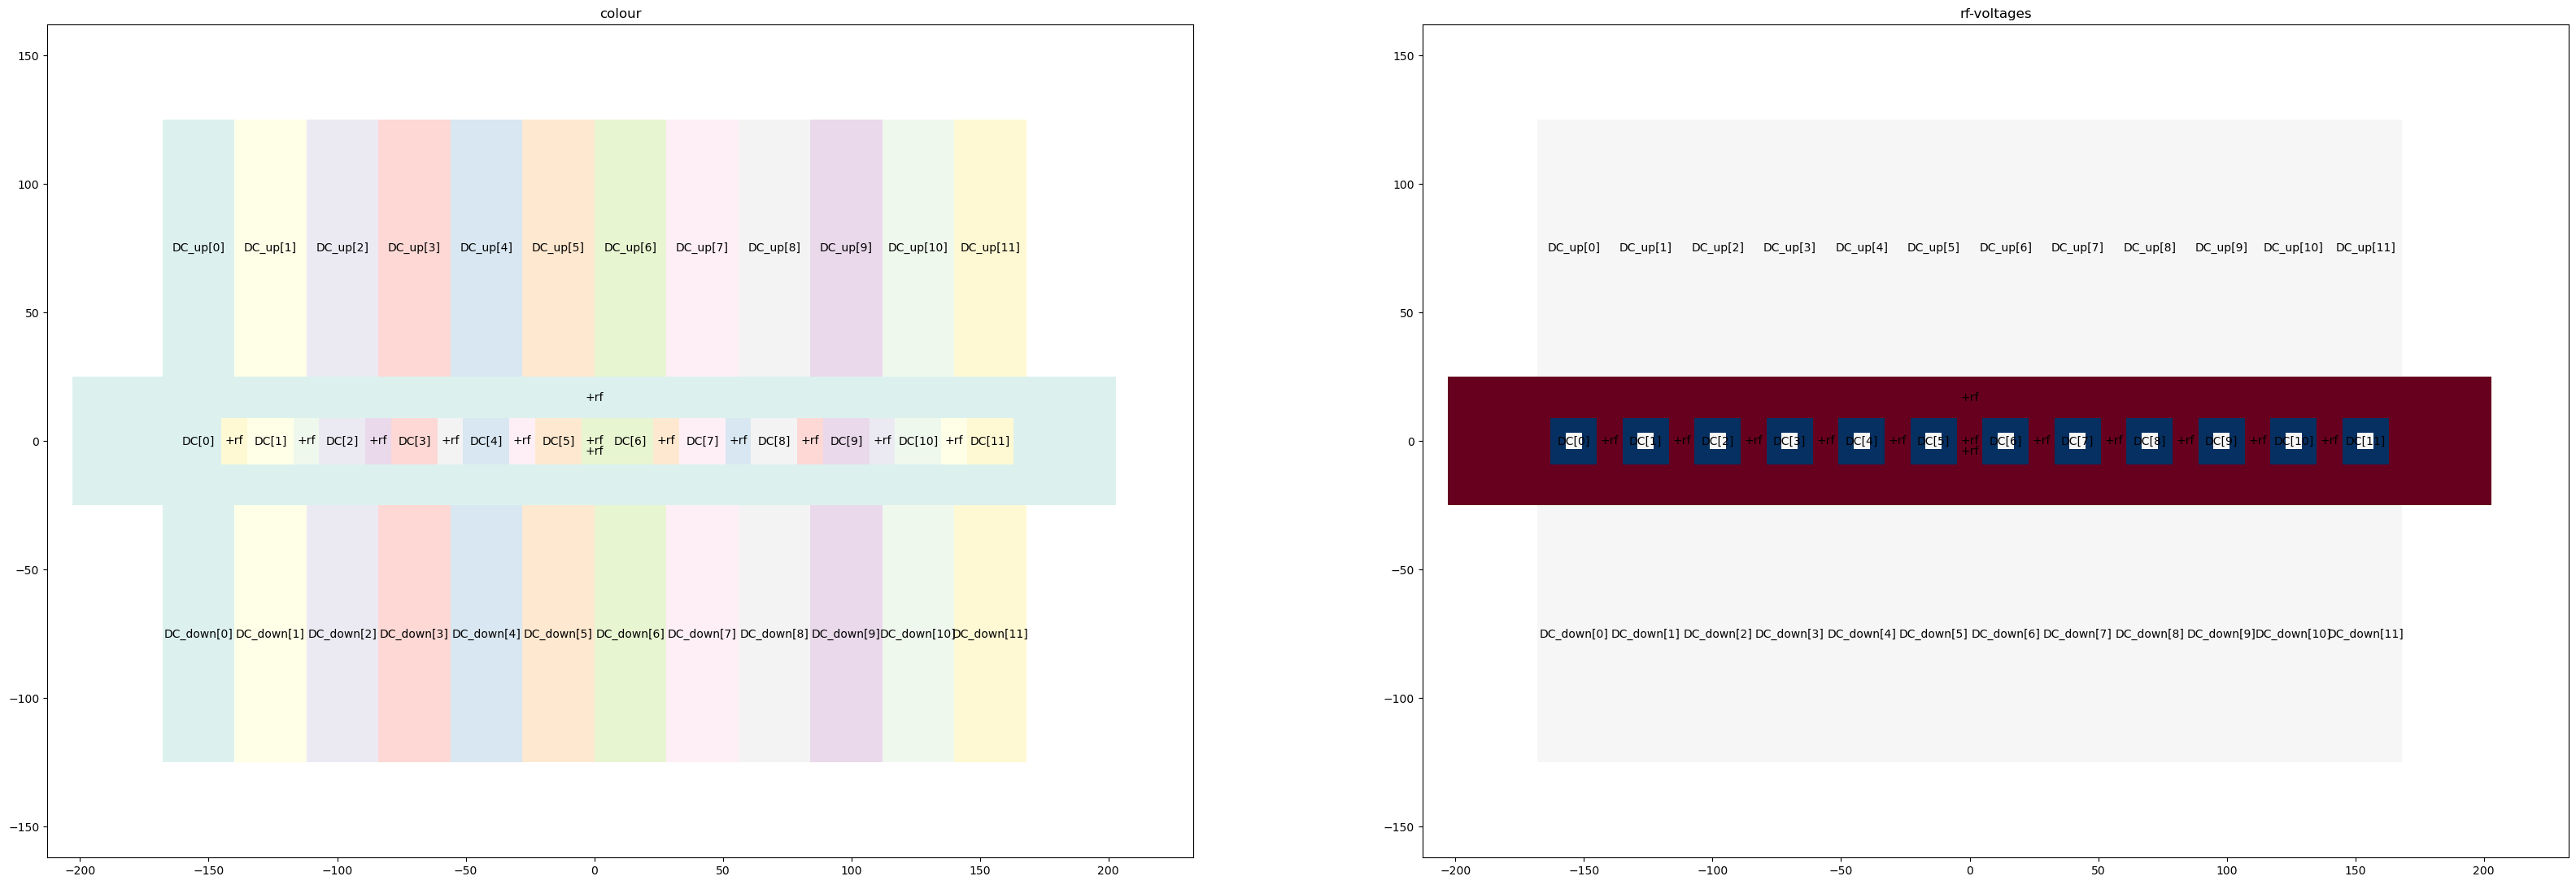

In [8]:
def array_trap(Urf, width, sq, n, inner_square, dc, side_dc, a, b, g, L, cheight=0, cmax=0):
    """
    Generates the trap from the article: https://doi.org/10.48550/arXiv.2211.07121
   
    
    Urf = [U+, U-]  rf amplitude of +rf and -rf squares
    width: float, width of +rf electrode borders
    sq: float, side of the inner square of rf+
    n: int, number of individual traps
    inner_square = [R_ex, r_in] external and inner sides of -rf square
    dc: float, side pf central DC square
    side_dc: height of side dc electrodes
    a: float, anisotropy: parameter, by which we multiply far left and
    far right width of +rf
    b: parameter, by which we multiply outer side width of rf+ electrode
    g: parameter, by which we multiply inner width of rf+ and rf-
    L: geomtry scale of the trap
    return: coordinates: list of coordinates to apply to polygon_trap()
    as [RF_coordinates, DC_coordinates]
            s: System object for electrode
    """
    dis = ((sq+width)*n+width)/2-(width+sq/2)
    rf_ex1 = [[-width*a-sq/2-dis, g*sq/2], [(n-0.5)*sq+(n-1+a)*width-dis, g*sq/2], [(
        n-0.5)*sq+(n-1+a)*width-dis, g*sq/2+b*width], [-a*width-sq/2-dis, g*sq/2+b*width]]
    rf_ex2 = [[-a*width-sq/2-dis, g*sq/2], [-a*width-sq/2-dis, -b*width-g*sq/2],
              [(n-0.5)*sq+(n-1+a)*width-dis, -g*sq/2-b*width], [(n-0.5)*sq+(n-1+a)*width-dis, g*sq/2], 
              [(n-0.5)*sq+n*width - 1*width-dis, g*sq/2], [(n-0.5)*sq + n*width - (1)*width - dis, -g*sq/2],
              [(n - 0.5)*sq + n*width - (n-1 + 1)*width - (n-1)*sq-sq-dis, -g*sq/2], [(n - 0.5)*sq + n*width - (n-1 + 1)*width - (n-1)*sq-sq-dis, g*sq/2] ]
    RF_coordinates = [np.array(rf_ex1)*L, np.array(rf_ex2)*L]
    
    rf_ex3 = []
    for i in range(n-1):
        rf_ex33 = [[(n - 0.5) * sq + n * width - (i + 2)
                      * width - (i+1) * sq-dis, g*sq / 2],
                      [(n - 0.5) * sq + n * width - (i + 2)
                      * width - (i+1) * sq-dis, -g*sq / 2],
                      [(n - 0.5) * sq + n * width - (i + 1)
                      * width - (i+1) * sq-dis, -g*sq / 2],[(n-0.5)*sq+n*width - (i+1)*width-(i+1)*sq-dis, g*sq/2]]
        rf_ex3.append([rf_ex33])
        RF_coordinates.append(np.array(rf_ex33)*L)

    electrodes = [
        ("+rf", [rf_ex1,
                 rf_ex2])]
    for i in range(n-1):
        # st = "-rf[" + str(i) +"]"
        electrodes.append(["+rf", rf_ex3[i]])

    R = inner_square[0]
    r = inner_square[1]

    rf_in = []
    for i in range(n):
        c = i*(sq+width)-dis
        top = np.array([[c - R/2, g*r/2], [c+R/2, g*r/2],
                       [c+R/2, g*R/2], [c-R/2, g*R/2]])
        bottom = np.array([[c-R/2, g*r/2], [c-R/2, -g*R/2], [c+R/2, -g*R/2], [c+R/2, g*r/2],
                          [c+r/2, g*r/2], [c+r/2, -g*r/2], [c-r/2, -g*r/2], [c-r/2, g*r/2]])
        rf_in.append([top, bottom])
        RF_coordinates.append(np.array(top)*L)
        RF_coordinates.append(np.array(bottom)*L)

    for i in range(n):
        # st = "-rf[" + str(i) +"]"
        electrodes.append(["", rf_in[i]])

    DC_coordinates = []

    dc_el = []
    for i in range(n):
        c = i * (sq + width)-dis
        elec = np.array([[c-dc/2, g*dc/2], [c-dc/2, -g*dc/2],
                        [c+dc/2, -g*dc/2], [c+dc/2, g*dc/2]])
        dc_el.append(np.array([elec]))
        DC_coordinates.append(np.array(elec)*L)

    dc_up = []
    dc_down = []
    for i in range(n):
        c = i * (sq + width) - dis
        elec_up = np.array([[c-dc/2-(R-r)/2-width/2, g*dc/2+g*(R-r)/2+b*width+side_dc], [c-dc/2-(R-r)/2-width/2, g*dc/2+g*(R-r)/2+b*width], [
                           c+dc/2+(R-r)/2+width/2, g*dc/2+g*(R-r)/2+b*width], [c+dc/2+(R-r)/2+width/2, g*dc/2+g*(R-r)/2+b*width+side_dc]])
        elec_down = np.array([[c - dc / 2 - (R - r) / 2 - width / 2, -(g*dc / 2 + g*(R - r) / 2 + b * width)],
                              [c - dc / 2 - (R - r) / 2 - width / 2, -
                               (g*dc / 2 + g*(R - r) / 2 + b * width+side_dc)],
                              [c + dc / 2 + (R - r) / 2 + width / 2, -
                               (g*dc / 2 + g*(R - r) / 2 + b * width+side_dc)],
                              [c + dc / 2 + (R - r) / 2 + width / 2, -(g*dc / 2 + g*(R - r) / 2 + b * width)]])
        dc_up.append(np.array([elec_up]))
        dc_down.append(np.array([elec_down]))
        DC_coordinates.append(np.array(elec_up)*L)
        DC_coordinates.append(np.array(elec_down)*L)

    for i in range(n):
        electrodes.append(["DC["+str(i)+"]", dc_el[i]])
        #coordinates.append(["DC[" + str(i) + "]", dc_el[i]*1e-6])
    for i in range(n):
        electrodes.append(["DC_up["+str(i)+"]", dc_up[i]])
    for i in range(n):
        electrodes.append(["DC_down["+str(i)+"]", dc_down[i]])

    # Polygon approach. All DCs are 0 for now
    s = System([PolygonPixelElectrode(cover_height=cheight, cover_nmax=cmax, name=f, paths=map(np.array, p))
                for f, p in electrodes])
    s["+rf"].rf = Urf[0]
    for i in range(n-1):
        # st = "-rf[" + str(i) +"]"
        s[i+1].rf = Urf[0]
    for i in range(n):
        # st = "-rf[" + str(i) +"]"
        s[i+n].rf = Urf[1]

    for i in range(n):
        st = "DC[" + str(i) + "]"
        s[st].dc = 0

    for i in range(n):
        st = "DC_up[" + str(i) + "]"
        s[st].dc = 0

    for i in range(n):
        st = "DC_down[" + str(i) + "]"
        s[st].dc = 0

    # creates a plot of electrode
    fig, ax = plt.subplots(1, 2, figsize=(40, 40))
    s.plot(ax[0])
    s.plot_voltages(ax[1], u=s.rfs)
    # u = s.rfs sets the voltage-type for the voltage plot to RF-voltages (DC are not shown)
    xmax = (n-0.5)*sq+((n-1)*width+width*a) * 1.2-dis
    ymaxp = (sq/2+(b+g)*width+side_dc)*1.2
    ymaxn = (sq/2+(b+g)*width+side_dc) * 1.2
    ax[0].set_title("colour")
    # ax[0] addresses the first plot in the subplots - set_title gives this plot a title
    ax[1].set_title("rf-voltages")
    for axi in ax.flat:
        axi.set_aspect("equal")
        axi.set_xlim(1.2*(-sq/2-a*width)-dis, xmax)
        axi.set_ylim(-ymaxn, ymaxp)

    return s, RF_coordinates, DC_coordinates


# Global definition of trap parameters. Used for all cells in this notebook
L = 1e-6 # µm length scale
Vrf = 140. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*200e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)
scale = Z/((L*Omega)**2*M)

U = [Urf, -1*Urf]
width = 10
sq = 18
n_squares = 12
inner_square = [18,6.4]
dc = 6.4
side_dc = 100
a = 4
b = 1.6
g = 1

dis = ((sq + width) * n_squares + width) / 2 - (width + sq / 2)

s, RF_electrodes, DC_electrodes = array_trap(U, width, sq, n_squares, inner_square , dc,side_dc, a,b,g,L, cheight = 100, cmax = 0)

## Initial secular frequencies

On the plots for this block, the initial secular frequencies of ions in each individual well are presented for each principle axis of oscillation. They are calculated for grounded DC electrodes.

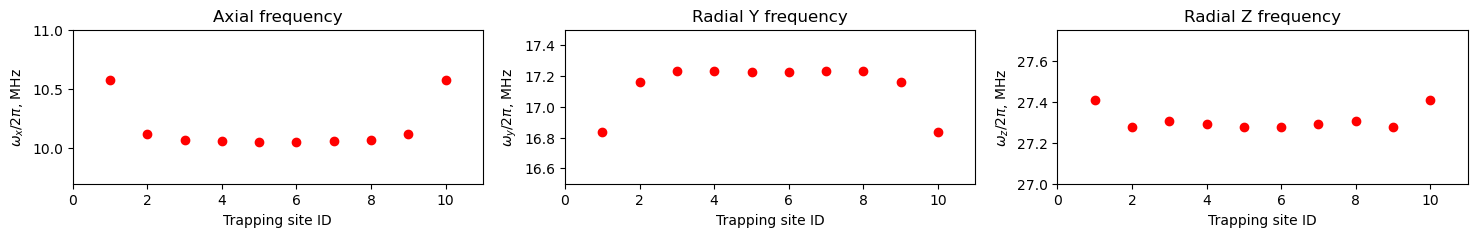

In [9]:
#determine all frequencies in minimums excluding 2 external traps
freqs_x = []
freqs_y = []
freqs_z = []
positions = []
cutoff = 1
# in trap there are 24 RF amplitudes, 36 DC voltages
u_set = np.zeros(24+36)

for i in range(cutoff, n_squares-cutoff):
    with s.with_voltages(dcs = u_set, rfs = None):
        #get potential well minimums
        x1 = s.minimum(np.array([(sq+width)*i-dis, 0, 20.4]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        positions.append(x1)
        # Get trap frequencies
        curv_z, mod_dir=s.modes(x1,sorted=False)
        omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
        freqs_x.append(omega_sec[0])
        freqs_y.append(omega_sec[1])
        freqs_z.append(omega_sec[2])

fig, ax = plt.subplots(1, 3, figsize=(18, 2))
ax[0].plot(range(1,11), freqs_x, 'ro')
ax[0].set_title("Axial frequency")
ax[0].set_ylabel('$\omega_x/2\pi$, MHz')
ax[0].set_xlabel('Trapping site ID')
ax[0].set_xlim(0, 11)
ax[0].set_ylim(9.7, 11)

ax[1].plot(range(1,11), freqs_y, 'ro')
ax[1].set_title("Radial Y frequency")
ax[1].set_ylabel('$\omega_y/2\pi$, MHz')
ax[1].set_xlabel('Trapping site ID')
ax[1].set_xlim(0, 11)
ax[1].set_ylim(16.5, 17.5)

ax[2].plot(range(1,11), freqs_z, 'ro')
ax[2].set_title("Radial Z frequency")
ax[2].set_ylabel('$\omega_z/2\pi$, MHz')
ax[2].set_xlabel('Trapping site ID')
ax[2].set_xlim(0, 11)
ax[2].set_ylim(27, 27.75)
plt.show()

## Optimization routine

In the following block, the optimized voltage set is obtained with the *sion.frequency_optimization()* function.  
Optimization routine may take a long time due to the complexity of functions. Optimization is performed to induce specific secular frequencies on each oscillation axis. It is possible to add micromotion minimization to the voltage optimization routine, but there is not enough degrees of freedom in this particular geometry. Consult with docs for more details on the usage. 

In [11]:
dots = np.array(positions)

# determining the desired secular frequency spectrum
axis = [0,1,2]
# frequency in Hz/2pi
omeg_x = np.array([1,1,1,1,1,1,1,1,1,1])*10.1e6
omeg_y = np.array([1,1, 0.98, 0.98, 0.96, 0.96, 0.97, 0.97, 0.99, 0.99])*17.2e6
omeg_z = np.array([1, 0.98, 0.98, 0.96, 0.96, 0.97, 0.97, 0.99, 0.99, 1])*27.3e6
omegas = [omeg_x, omeg_y, omeg_z]

# optimization parameters
start_dcset = np.zeros(36)
numbers = 0
voltage_bounds = (-15,15)
ion_masses = M


# executing optimization
dcset = sn.frequency_optimization(s, ion_masses, dots, axis, omegas, start_dcset, numbers=numbers, find_initial_guess=False,
                                  callback_num=20, micro=0, voltage_bounds=voltage_bounds, tol=1e-18)

Initial loss = 0.06747762068386408


Optimizing voltages: 20it [01:33,  4.42s/it]

Current loss = 0.003943996706067331
Current uset = [-0.16808856117342114, 0.8405163845419376, 1.0236668756363556, 0.8211487254136027, 0.8263045719437656, 0.8432889400210333, 0.567515633248994, 0.6198968836486013, 0.5428361901496362, 0.7734997394229991, 1.0915488821175923, -0.3015108597644883, 0.11178997468773981, 0.8327258626387047, -0.054558186829985006, -0.23796280845847942, 0.06781664615396873, -0.2977893321558205, -0.21790560436116477, -0.01854128794186771, -0.22256106491773764, -0.008526224164018223, 0.35384617690084613, 0.7197628060893059, 0.11175203394256977, 0.8306776429793092, -0.05538627802032804, -0.23810321429319178, 0.06762135199683093, -0.2979737856702204, -0.21762384482757552, -0.01919531180636255, -0.22257160974545007, -0.008180226642322949, 0.3553919383230822, 0.7195579677102902]


Optimizing voltages: 40it [03:22,  5.14s/it]

Current loss = 0.003508702924722828
Current uset = [-0.1885662176219564, 0.3968208777166023, 0.8637107015371536, 0.690409968079628, 0.7178720575066797, 0.7173369917523779, 0.40437190799580874, 0.48059782078435787, 0.43936725997934245, 0.7699537825242657, 1.822402256264488, -0.8989548039030526, -0.4038821294545641, 1.0597838284392327, -0.0974680944680358, -0.1952607078071784, 0.06810383547923021, -0.32648650833339604, -0.24799563058561505, -0.04661648413054566, -0.39366918934817385, 0.33208725499229375, -1.020514082241992, 2.626926689684814, -0.4063189085429938, 1.0456121574092934, -0.1257427218467925, -0.21475451296688677, 0.06272169357559451, -0.3338673954886185, -0.24463834172342552, -0.03889096730183745, -0.38100889837456076, 0.34690950572403867, -1.006220639816008, 2.6250398974975453]


Optimizing voltages: 60it [05:01,  5.66s/it]

Current loss = 0.0028634989048247016
Current uset = [-1.1840749456873958, 1.1708793317663235, 1.2089585250355648, 0.8507597498046505, 0.830200493547407, 0.878756613860875, 0.5671881234044049, 0.6289243898129275, 0.6820954936908464, 1.0474231982031716, 2.2234204524701378, -0.795208430389966, 0.4228104093246183, 1.0757367569439478, 0.7726977286227391, 0.5578881307927981, 0.6601168214521667, -0.12974905502159195, -0.2588917120763394, -0.15564258407452236, -0.5699605534849405, 0.03976435176054128, -1.6153744729884973, 3.0972893707311475, 0.3089757144509687, 0.567815339033665, -0.8402929032824049, -0.5232326782648098, -0.4166470659513821, -0.6937690149397676, -0.30299279897000453, 0.09799045697912054, -0.22875677917027087, 1.0739705515191995, -1.0556549460338163, 3.267000718870345]


Optimizing voltages: 80it [06:37,  5.73s/it]

Current loss = 0.0005829127840234419
Current uset = [-2.1299279271412486, 1.9048596143783096, 1.8232702643543282, 1.6590871160358136, 1.1846175184852983, 1.0919997111410784, 0.7555342483957912, 0.7409385028800972, 0.7240212050753874, 0.7427170554777885, 2.8453778891761554, -1.3098286238399297, 0.6036014997456529, 2.343433093997286, 2.793723648905754, 0.4946306522574683, 1.3753683709556812, 0.13231355909360293, -0.508229789958935, -0.45945006424975654, -1.0222541841216002, -0.002674890085794225, -3.8974393899945046, 5.318454765962661, -0.16514704448846448, 0.1890199436404592, -0.6771188789376476, -0.5896631457331296, -0.6959867570393939, -1.115753954691593, -0.38628654694595055, 0.23146872066453708, -0.7225969978004516, 3.075299227592955, -1.7731466336914716, 5.9534176934047]


Optimizing voltages: 100it [08:10,  5.01s/it]

Current loss = 0.00012727963951169493
Current uset = [-2.2272442670154327, 2.0572440445457536, 2.0483864677660604, 1.9981000913569118, 1.3590320882036642, 1.3592779455735724, 0.993067782939337, 0.877579141149587, 1.0195550859795857, 0.890081934620446, 2.705547347707423, -1.2419179064989025, 0.7154328321009047, 2.632231378426611, 2.9550609158546206, 0.23793547634612047, 1.9225438859104647, 0.10046653564340284, -0.7068143196257325, -0.2884901061741159, -0.6256599523209684, -0.20861324085151878, -4.13532500883179, 5.410270453815169, -0.19327703356012588, 0.17414355457907646, -0.685106490319782, -0.48841290744088955, -0.7671254925279243, -1.1397454852579172, -0.19848324239651052, 0.3104303155445338, -1.4437035108499052, 3.181423662159688, -1.2719571832757575, 6.173278764642118]


Optimizing voltages: 120it [09:50,  5.62s/it]

Current loss = 3.8768215620264575e-05
Current uset = [-2.2729288912421963, 2.1699562571791495, 2.1579301852825314, 2.0641748077492865, 1.21791831214151, 1.3455905161421677, 0.9323156938231209, 0.7714568124940407, 0.9808678525852973, 0.8455153185077127, 2.5076015846544117, -1.1266014377432165, 0.7656333871004496, 2.6599580085956425, 3.0747054632556954, 0.18905317875623343, 2.3110998826772122, 0.029787659088863296, -0.898942596185415, -0.5011525161689016, -0.3824718097173743, -0.40636335042058697, -4.0716777082485605, 5.2957394941015945, -0.17089619283325194, 0.14735794124064291, -0.6278704274848692, -0.49881705469049326, -0.7921428929128557, -1.3603137189283483, -0.03830668427288579, 0.5112321268376053, -1.7015676776414816, 3.1460851505901872, -0.8516763508765745, 6.069647767414656]


Optimizing voltages: 140it [11:29,  5.94s/it]

Current loss = 1.9325666579380464e-05
Current uset = [-2.2660698086821833, 2.1750550146417496, 2.107727381048799, 2.061415533828928, 1.2514204057428202, 1.3759741851087022, 0.950140193991218, 0.7719195834383925, 1.0228746621994906, 0.9221923554016955, 2.511870688849125, -1.0957347863823172, 0.7699536936294772, 2.67280048491532, 3.1696070585284915, 0.1146637821945005, 2.212612975045023, 0.07547845608412258, -0.9503048310634837, -0.6634831569951152, -0.22237240444280695, -0.4284764578872872, -4.026099381449502, 5.234143266608129, -0.15574497175234367, 0.15580111561708293, -0.6600372198714898, -0.5147477902236602, -0.7567411887569253, -1.3895140802117085, 0.01894707549494233, 0.7320151302981921, -1.76118934215308, 3.051008730409208, -0.7902240050084631, 5.9969363432395575]


Optimizing voltages: 160it [13:08,  4.88s/it]

Current loss = 9.65993747680056e-06
Current uset = [-2.2678027925581388, 2.173000857685882, 2.095465996524822, 2.0689210248369028, 1.2740506174812343, 1.3740558393880553, 1.000539372050112, 0.7917848645112895, 1.0721550475655148, 0.9604309549408845, 2.5609786329757505, -1.0800566586121558, 0.7543379354771504, 2.6060416813199665, 3.176165148800305, 0.09925341642749402, 2.153199200137537, 0.19826479218155546, -0.9680787338144277, -0.7671420129711655, -0.16119911654525543, -0.46674435673383896, -3.9521512418474645, 5.1975486573322085, -0.1368330710095507, 0.15243697149128957, -0.6647929900640929, -0.5096487552555063, -0.7310461736338284, -1.420182319128022, -0.031509835528080246, 0.9076435764060253, -1.8264827113845599, 3.113756203338685, -0.7570209828775273, 5.942166724134776]


Optimizing voltages: 180it [14:52,  5.49s/it]

Current loss = 4.082699297592197e-06
Current uset = [-2.2546738945115345, 2.1100080190225796, 2.0698972757761678, 2.0421103845367425, 1.2960098963175846, 1.381810034304373, 1.0359182606355442, 0.8137580086480556, 1.1317145957169192, 0.9813205381294337, 2.6490920947029197, -1.0782718427311133, 0.7135528201981642, 2.584182596906795, 3.071364802591955, 0.13454907007313338, 2.060860529742879, 0.24219128791184485, -0.9571665464730645, -0.8100706038656402, -0.13424609628330156, -0.5182992977904574, -3.8374478518174184, 5.1691998879209375, -0.1686948419502327, 0.16594103579171837, -0.6672020971396425, -0.5092650486421814, -0.7107733375247709, -1.39753313220403, -0.08635977839739031, 1.0470880894103958, -1.9061133979063702, 3.272510951418831, -0.8134505621167082, 5.865584935468881]


Optimizing voltages: 200it [16:19,  4.14s/it]

Current loss = 1.5785405140784247e-06
Current uset = [-2.240399226499432, 2.0142132320437076, 2.0401148459744665, 2.0124685368188464, 1.2946210792503179, 1.3880491365173677, 1.0424176344667355, 0.8141718098916743, 1.1421084137106254, 0.9945566970157406, 2.678736786340062, -1.081911205275551, 0.6422429111480947, 2.5766642207346893, 2.971729543383052, 0.15290548458413375, 2.0434731363349483, 0.2281782617040393, -0.9371529168440835, -0.8506414718728399, -0.06518366387285, -0.5323427355019184, -3.782680613969218, 5.143855157326005, -0.23351495256222, 0.18267959852573454, -0.6674326325470726, -0.49417881389949236, -0.7155047621271055, -1.3668195740292743, -0.10201902514777186, 1.1240177873097956, -1.957703647398704, 3.2948389753479574, -0.9174879715660352, 5.796475358005328]


Optimizing voltages: 220it [17:50,  4.79s/it]

Current loss = 5.319273764303362e-07
Current uset = [-2.234715242459149, 1.964194441801421, 2.0391358594472564, 2.023736538273265, 1.2908251550169303, 1.3845516895889363, 1.0440500187288855, 0.8115557547261592, 1.1290437582027537, 0.9820780665092539, 2.670648316166276, -1.0846024516705859, 0.5944629314776744, 2.5741799571774506, 2.9666779997684256, 0.1475732630761034, 2.0795112177475183, 0.23376058651771417, -0.9140176794938151, -0.8652654914418093, -0.049696819810128384, -0.5379413307115765, -3.7733767103219917, 5.138635986230357, -0.2779711619487442, 0.18339765021501497, -0.6552608437677148, -0.48409561547026586, -0.7137539279622844, -1.3701504794291721, -0.1229788125402073, 1.124246728418707, -1.9705630773985272, 3.2940424851782413, -0.9524157639156889, 5.778331168214988]


Optimizing voltages: 240it [19:11,  4.21s/it]

Current loss = 6.129686392292837e-08
Current uset = [-2.22890941458186, 1.9215830088769879, 2.03536805231742, 2.030691986005434, 1.2966527559560352, 1.3954373255396857, 1.0527310787894029, 0.8191760560562065, 1.1345791300187802, 0.9849392490632516, 2.6804719503886067, -1.086830031928349, 0.5499174691171108, 2.585078952585905, 2.9859946151887717, 0.14648174208355555, 2.1010927075167722, 0.22120337136628349, -0.8998126336835593, -0.8755797230302467, -0.03519728774975214, -0.5443859848296633, -3.7591686353935336, 5.135502796251402, -0.32420997384157746, 0.18468988133452255, -0.6438719254196505, -0.48077952891404024, -0.7197819095848201, -1.3622998639611887, -0.13067261710421374, 1.1371296783599665, -1.98309779775833, 3.306690615277691, -0.9783525881334606, 5.765405810361972]


Optimizing voltages: 260it [20:39,  4.34s/it]

Current loss = 1.1307215614312795e-08
Current uset = [-2.230083467562021, 1.9274546171593074, 2.0380778781733535, 2.034800732622276, 1.2978184817548166, 1.397719336417983, 1.0555322916876362, 0.8203633017944706, 1.1371041684988263, 0.9869490213182609, 2.6821358141264717, -1.0860971225897964, 0.552485951291902, 2.5825546930778693, 2.9966262545948643, 0.1442008647282593, 2.107166316699132, 0.22142250879079511, -0.9027994053287859, -0.8744041930032256, -0.04017787952453773, -0.5438373394337731, -3.7604459758137976, 5.136443600491285, -0.32035456806914087, 0.18270703675584435, -0.6432415391387333, -0.480885358889096, -0.7202215202742966, -1.3647802231791484, -0.1303365696321649, 1.1385177148922856, -1.9803921629199703, 3.3084025884011954, -0.969848531968631, 5.7689547081084465]


Optimizing voltages: 280it [22:06,  4.22s/it]

Current loss = 4.501907299942159e-09
Current uset = [-2.230412527089651, 1.9288244130506527, 2.037603976576084, 2.035388753223057, 1.2976020897260054, 1.3983099094699394, 1.0564944573175028, 0.82082294175431, 1.1383285397661382, 0.9884811351514685, 2.683488919063232, -1.084797028345167, 0.5538119456432136, 2.58202591255022, 2.9966359212964915, 0.13988693633054414, 2.1087407644068383, 0.22144489580322363, -0.903585168928832, -0.8758994261897245, -0.03969795598814489, -0.5439468981819846, -3.75828980850102, 5.135008221021409, -0.31832874584683796, 0.18303237977472966, -0.6448861347791904, -0.4797294606891326, -0.7203156120969271, -1.3652519326695347, -0.12983807673611372, 1.141903161127353, -1.9796730981804085, 3.3077590235974026, -0.968085102304435, 5.766183149395412]


Optimizing voltages: 300it [23:34,  4.34s/it]

Current loss = 1.8467345584529112e-09
Current uset = [-2.230536843304456, 1.9282717452882183, 2.036709722452161, 2.0349001190226486, 1.2974859239690961, 1.3980216738001734, 1.0563730218776188, 0.8209307152986491, 1.138345466568102, 0.9882942547124867, 2.6836416862, -1.0831967587330622, 0.5532767610648269, 2.580613539490873, 2.9966913611949746, 0.13886439822622487, 2.1081995109435794, 0.22121070398944093, -0.9026506949361262, -0.8762154469071894, -0.039111590886798005, -0.5450856211601052, -3.755098491190167, 5.132800042596216, -0.3179615097621089, 0.18306914074401717, -0.6451443814327926, -0.4795094200291803, -0.7203520123349543, -1.3644628188398709, -0.1306651752330444, 1.1422911514653555, -1.979747571782518, 3.3082260860119357, -0.9671968115997986, 5.761412726208302]


Optimizing voltages: 320it [25:13,  5.55s/it]

Current loss = 7.787127027646195e-10
Current uset = [-2.2303897224393525, 1.9274279249366655, 2.0366791705098715, 2.0348579005829914, 1.2978738706144306, 1.3985542974391976, 1.0568731411030152, 0.8212944377998035, 1.138646121995346, 0.9886574663097059, 2.684251094608654, -1.082065406923529, 0.5525778948693347, 2.5811879957020882, 2.9965715444931953, 0.13960745274017367, 2.108033797371622, 0.2205896738973471, -0.9016634995384184, -0.8769289315319463, -0.038797944811686205, -0.5454158464269362, -3.7526835268054555, 5.131160629513631, -0.31896561949601104, 0.1831395870837041, -0.6448469511179135, -0.47970906958125503, -0.7204575297878187, -1.3637901542546902, -0.13155830433074736, 1.1436264870715205, -1.9793619615053841, 3.3079858665922957, -0.9671451396233404, 5.757818873706643]


Optimizing voltages: 340it [26:46,  4.34s/it]

Current loss = 1.7786151136837446e-10
Current uset = [-2.2303082664213267, 1.9269189570980312, 2.037261786161967, 2.035335654618577, 1.298287303325092, 1.3988796475005583, 1.0575385670628694, 0.8215577946326825, 1.1387812933192856, 0.9888342928945968, 2.684610705769811, -1.0816644973475846, 0.5519720196271815, 2.5813611029581427, 2.9960421838800917, 0.1403515918870842, 2.1085398957748755, 0.2208891933451038, -0.9010678890162408, -0.877410392473635, -0.038789922391646074, -0.5453996852711158, -3.751691358774635, 5.130488230725015, -0.31977723142160425, 0.1831209675911798, -0.6444673842026549, -0.4795074248532547, -0.720548091375709, -1.3635992274186304, -0.13255845511411168, 1.1445482096721562, -1.9789828335979933, 3.3077524390526167, -0.9675434592010893, 5.75629110809569]


Optimizing voltages: 360it [28:23,  4.95s/it]

Current loss = 6.470351440763e-11
Current uset = [-2.2302632827708666, 1.9266249475554198, 2.037266695958742, 2.0354334471815263, 1.2983150063513047, 1.3988766135960369, 1.057570501942043, 0.8215461827162979, 1.1387092804961712, 0.988831477952576, 2.6846953705651875, -1.0819622726979694, 0.5517083492812526, 2.581605531626836, 2.9960958176839054, 0.14032121139414697, 2.108666159217549, 0.22098246933126042, -0.9010502767110746, -0.8774279251290193, -0.03883088640287115, -0.5451976327558076, -3.752036734901395, 5.130805635260954, -0.3201309962148754, 0.1831705848289258, -0.644420720783829, -0.47950487083649185, -0.720499578994944, -1.3636529410316325, -0.13261635295489754, 1.1445157160412476, -1.9789305217254158, 3.307742860116442, -0.9682031110650985, 5.756838614635402]


Optimizing voltages: 364it [28:41,  4.73s/it]

Final loss = 5.2949545766628676e-11
Final uset = [-2.2302613364479758, 1.9265820618445646, 2.037243187963086, 2.0354163809516894, 1.2983018502021901, 1.3988868971516693, 1.0575676648821006, 0.8215467974167354, 1.1386999687363721, 0.9888082340963821, 2.6846959490227555, -1.0820017965348052, 0.5516477673788186, 2.581576458106951, 2.9961219235310588, 0.1403459400942587, 2.1086742722021294, 0.22094383885127128, -0.9010551123212088, -0.8774122763861383, -0.03884126870844818, -0.5451777345351465, -3.7520767948357983, 5.130838624485165, -0.3201768684169289, 0.18316621632173902, -0.6443897545586329, -0.4795218391800514, -0.7205024739679449, -1.3636461725746005, -0.13259560704377546, 1.1445130262537533, -1.9789439782291558, 3.3077708795996767, -0.968292168423829, 5.756896469616251]


## Resulting secular frequency spectrum

This block shows plots of the resulting secular frequency spectrum and DC voltage distribution

In [ ]:
uset = dcset

freqs_x = []
freqs_y = []
freqs_z = []
positions = []
cutoff = 1
u_set = np.append(np.zeros(24), uset)
sq = 18
width = 10
omegas = []
zz = []
zz_rf = []

for i in range(cutoff, n_squares-cutoff):
    x0 = s.minimum(np.array([(sq+width)*i-dis, 0, 20.5]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter': 10000000})
    with s.with_voltages(dcs = u_set, rfs = None):
        #get potential well minimums
        x1 = s.minimum(np.array([(sq+width)*i-dis, 0, 20.5]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter': 10000000})
        positions.append(x1)
        zz_rf.append(x0[2])
        zz.append(x1[2])
        # Get trap frequencies
        curv_z, mod_dir=s.modes(x1,sorted=False)
        omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
        omega_sec, _=sn.single_ion_modes(s, x1, M, L=L, mathieu=False, r=2, Omega=Omega) 
        omega_sec *= 1e-6
        freqs_x.append(omega_sec[0])
        freqs_y.append(omega_sec[1])
        freqs_z.append(omega_sec[2])
        omegas.append(list(omega_sec*1e6))

fig, ax = plt.subplots(1, 3, figsize=(18, 2))
ax[0].plot(range(1,11), freqs_x, 'ro')
ax[0].set_title("Axial frequency")
ax[0].set_ylabel('$\omega_x/2\pi$, MHz')
ax[0].set_xlabel('Trapping site ID')
ax[0].set_xlim(0, 11)
ax[0].set_ylim(10, 10.2)

ax[1].plot(range(1,11), freqs_y, 'ro')
ax[1].set_title("Radial Y frequency")
ax[1].set_ylabel('$\omega_y/2\pi$, MHz')
ax[1].set_xlabel('Trapping site ID')
ax[1].set_xlim(0, 11)
ax[1].set_ylim(16.25, 17.5)

ax[2].plot(range(1,11), freqs_z, 'ro')
ax[2].set_title("Radial Z frequency")
ax[2].set_ylabel('$\omega_z/2\pi$, MHz')
ax[2].set_xlabel('Trapping site ID')
ax[2].set_xlim(0, 11)
ax[2].set_ylim(26, 27.5)

with s.with_voltages(dcs = u_set):    
    
    fig, ax = plt.subplots(1,1, figsize=(40, 40))
    s.plot_voltages(ax, u=s.dcs)
    #u = s.dcs sets the voltage-type for the voltage plot to DC-voltages (RF are not shown)
    xmax = 220
    ymaxn = 150
    ymaxp = 150
    ax.set_title("dc-voltages")
    ax.set_aspect('equal')
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymaxn, ymaxp)
    #Add colorbar
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(u_set), vmax=np.max(u_set))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, shrink = 0.6, aspect = 35)
    
    """cb = plt.colorbar(ax=ax[2], shrink=0.9)"""
    cb.ax.tick_params(labelsize=28)
    cb.set_label('Voltage', fontsize = 28)


## Potential

Potential of the trap, calculated with *electrode* package. It demonstrates indvidual wells and potential minimums in each well. If the simulation is correct, the final ion positions will coincide with the minimum coordinates.

RF pseudopotential minimum: -0.01546 eV at (14.1, 0.252, 20.5)µm
secular frequencies: (10.1, 16.51, 26.48) MHz
in directions
a: [ 9.96688955e-01 -8.13046220e-02  8.28030570e-04] 
b: [ 0.0813087   0.99665433 -0.00830953] 
c: [-1.49656776e-04  8.34934627e-03  9.99965132e-01]


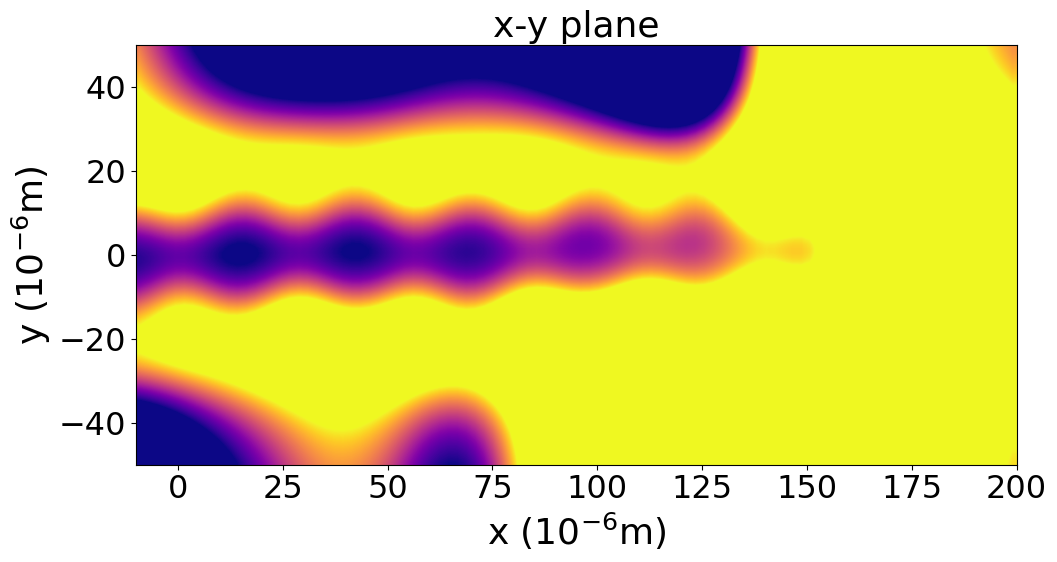

In [20]:
with s.with_voltages(dcs = u_set, rfs = None):
    x_ini = [14.27643,  0.60607, 20.50245]
    x0 = s.minimum(x_ini, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    p_tot0=s.potential(x0, 0)[0]
    print("RF pseudopotential minimum: %.4g" % p_tot0,"eV at (%.3g, %.3g, %.3g)µm" % (x0[0], x0[1], x0[2]))

    curv_z, mod_dir=s.modes(x0,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)

    # 2D plot settings

    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -10, 200 #set the plot ranges
    ymin, ymax = -50, 50
    zmin, zmax = 0, 50
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(0.003,0.4, 0.005)# set the range for contour lines (range in eV)
    v_min, v_max = 0., 0.4 #set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,12)

    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    #CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')


## Simulation of ion motion

These blocks show the results of the simulation of an ion crystal in this trap. Each ion is placed in the respective individual well.

In [21]:
def min_positions(minim, n_squares):
    positions = []
    for i in range(1,n_squares-1):
        positions.append([(i*(sq+width)-dis)*L, 0, minim])
        
    return positions

positions = min_positions(20e-6, n_squares)

name = Path('individual_wells_voltage_optimization.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}
Beions = {'mass': 9, 'charge': 1}

rf_set_plus = np.array([Vrf for i in range(13)])
rf_set_minus = np.array([-Vrf for i in range(24)])
rf_set = np.concatenate([rf_set_plus, rf_set_minus])

dc_set = np.zeros(len(uset))

Omegas = [Omega for i in range(37)]

sim.append(pl.placeions(Caions, positions))

sim.append(sn.polygon_trap(Omegas, rf_set, dc_set, RF_electrodes, DC_electrodes))


sim.append(pl.langevinbath(0, 1e-7))

sim.append(pl.dump('posvol.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(4e4))
try:
    sim.execute()
except:
    pass

Reducing timestep to 3.978873577297384e-11 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  10 settings made for charge
10 atoms in group 1
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  T

C:\Users\User_A\anaconda3\Lib\site-packages\pylion-0.5.2-py3.11.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Plots of ion trajectory

This block demonstrate the plot of an ion trajectory in the trap during the simulation.

C:\Users\User_A\AppData\Local\Temp\ipykernel_10068\2728041630.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


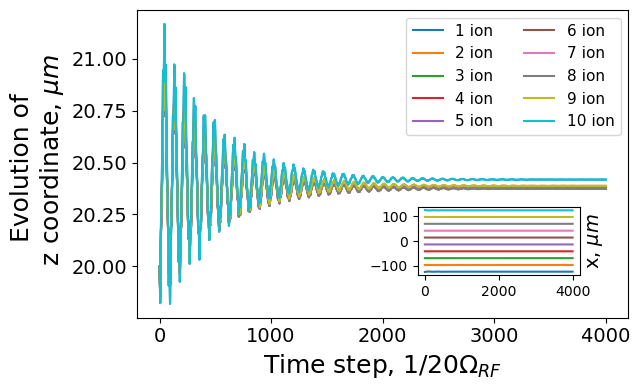

In [22]:
#import data
_, data = pl.readdump('posvol.txt')
data *=1e6

#plotting routine
fig, ax = plt.subplots(1,1,figsize = [6.5, 4] )
for n in range(n_squares-2):
    st = str(n+1)
    ax.plot(data[:, n, 2], label = st + ' ion')
plt.locator_params(axis='x', nbins=5)
ax.legend(prop = {'size': 11}, ncol = 2)
ax.tick_params(axis='both', which='major', labelsize=14)
left, bottom, width, height = [0.65, 0.3, 0.25, 0.17]
ax2 = fig.add_axes([left, bottom, width, height])
for n in range(n_squares-2):
    ax2.plot(data[:, n, 0])
ax2.set_ylabel('x, $\mu m$', fontsize = 14)
ax2.yaxis.set_label_position("right")
ax.set_ylabel('Evolution of \n z coordinate, $\mu m$', fontsize = 18)
ax.set_xlabel('Time step, $1/20\Omega_{RF}$', fontsize = 18)
plt.tight_layout()
plt.savefig('array_trap_evolution.eps')
plt.show()

## Calculation of normal modes 

In this block, the normal modes of this crystal in the presented voltage configuration is demonstrated. The normal mode spectrum is associated with the Fig. 5 from the [1]. On the plots, the normal mode interaction matrices in all 3 axes are demonstrated.

Axial freqs: [10100008. 10100101. 10100304. 10100533. 10100790. 10101022. 10101230.
 10101413. 10101540. 10101635.]
Radial freqs y: [16511560. 16511806. 16683595. 16683837. 16855584. 16855824. 17027622.
 17027888. 17199647. 17199934.]
Radial freqs z: [26207758. 26207917. 26480723. 26480931. 26753805. 26754011. 27026821.
 27026988. 27299831. 27299926.]
X Normal Vectors:
 [[-0.403 -0.387 -0.362 -0.334 -0.304 -0.296 -0.288 -0.268 -0.253 -0.215]
 [ 0.431  0.361  0.248  0.113 -0.029 -0.168 -0.293 -0.377 -0.434 -0.406]
 [ 0.414  0.209 -0.075 -0.316 -0.423 -0.396 -0.215  0.065  0.328  0.43 ]
 [-0.4   -0.02   0.362  0.427  0.144 -0.243 -0.442 -0.261  0.133  0.406]
 [ 0.344 -0.189 -0.431 -0.056  0.392  0.339 -0.178 -0.441 -0.097  0.392]
 [ 0.301 -0.35  -0.266  0.359  0.271 -0.322 -0.292  0.328  0.3   -0.356]
 [-0.24   0.425 -0.054 -0.396  0.278  0.267 -0.43   0.002  0.424 -0.296]
 [-0.193  0.453 -0.38  -0.001  0.376 -0.387  0.056  0.319 -0.417  0.208]
 [ 0.115 -0.318  0.423 -0.37   0.161  0.134

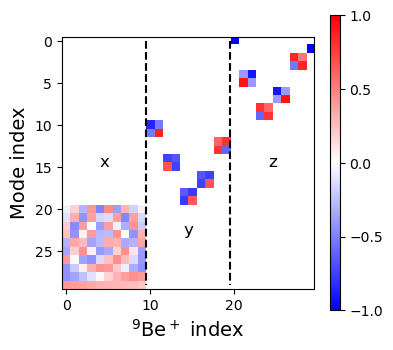

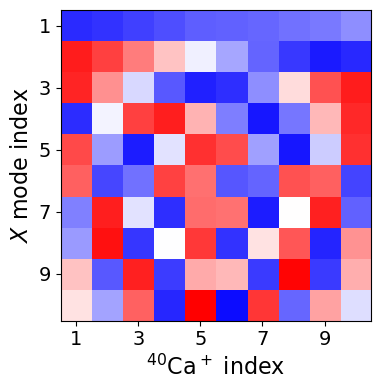

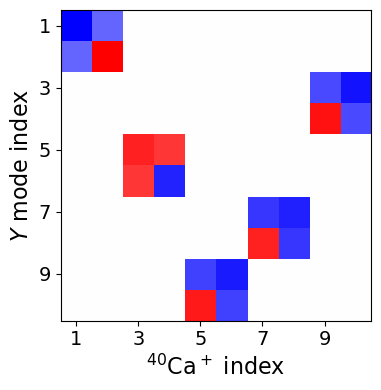

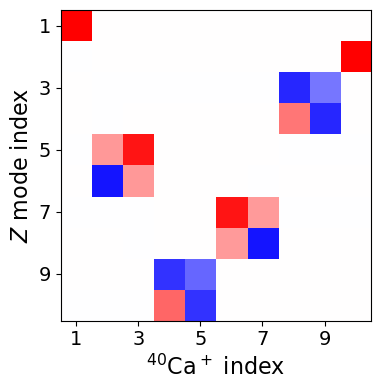

In [24]:
omegas = np.array(omegas)
    

ion_number = 10
ion_masses = [M for el in range(ion_number)]

_, data = pl.readdump('posvol.txt')


final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]
sort = np.argsort(final_x)

ion_positions = np.zeros([ion_number, 3])

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

equilibrium_positions = []
for i in range(ion_number):
    equilibrium_positions.append(np.array([np.mean(data[3800:, i, 0]), np.mean(data[3800:, i, 1]), np.mean(data[3800:, i, 2])]))
equilibrium_positions = np.array(equilibrium_positions)

freqs, modes = sn.normal_modes(equilibrium_positions, omegas, ion_masses, linear = True)

axial_freqs = freqs[0]
radial_freqs_y = freqs[1]
radial_freqs_z = freqs[2]
axial_modes = modes[0]
radial_modes_y = modes[1]
radial_modes_z = modes[2]

np.set_printoptions(0, suppress = True)
print('Axial freqs:', axial_freqs)
print('Radial freqs y:', radial_freqs_y)
print('Radial freqs z:', radial_freqs_z)

np.set_printoptions(3, suppress = True)
print('X Normal Vectors:\n', axial_modes)

print('Y Normal Vectors:\n', radial_modes_y)

print('Z Normal Vectors:\n', radial_modes_z)

freqs, modes = sn.normal_modes(ion_positions, omegas, ion_masses, linear = False)

plt.figure(figsize = [4,4])
plt.imshow(modes[::-1,:] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
plt.colorbar(shrink = 0.8, aspect = 30, ticks = [-1, -0.5, 0, 0.5, 1])
plt.tight_layout()
plt.vlines([9.5,19.5], ymin = 0, ymax = 29 ,linestyles = 'dashed', color = 'k')
plt.locator_params(axis='x', nbins=3)
plt.text(4, 15,'x', fontsize = 'large')
plt.text(14,23,'y',fontsize = 'large')
plt.text(24, 15,'z',fontsize = 'large')
plt.xlabel('$^{9}$Be$^+$ index', fontsize = 14)
plt.ylabel('Mode index', fontsize = 14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(axial_modes[:] / np.max(np.abs(axial_modes[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$X$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(radial_modes_y[::-1,:] / np.max(np.abs(radial_modes_y[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$Y$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(radial_modes_z[::-1,:] / np.max(np.abs(radial_modes_z[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$Z$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

Mode index: 1, Frequency: 10100008 Hz
Vector: [-0.40308, -0.38709, -0.36237, -0.33405, -0.3042, -0.29569, -0.28817, -0.26766, -0.25313, -0.21459, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0]
Mode index: 2, Frequency: 10100101 Hz
Vector: [0.43068, 0.36085, 0.24795, 0.11254, -0.02902, -0.16773, -0.29276, -0.37698, -0.43429, -0.40589, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0]
Mode index: 3, Frequency: 10100304 Hz
Vector: [0.41413, 0.20945, -0.07526, -0.31602, -0.42282, -0.39631, -0.21519, 0.06462, 0.32783, 0.43046, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0]
Mode index: 4, Frequency: 10100533 Hz
Vector: [-0.40047, -0.01994, 0.36173, 0.42731, 0.14359, -0.24321, -0.442, -0.26102, 0.13296, 0.40602, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

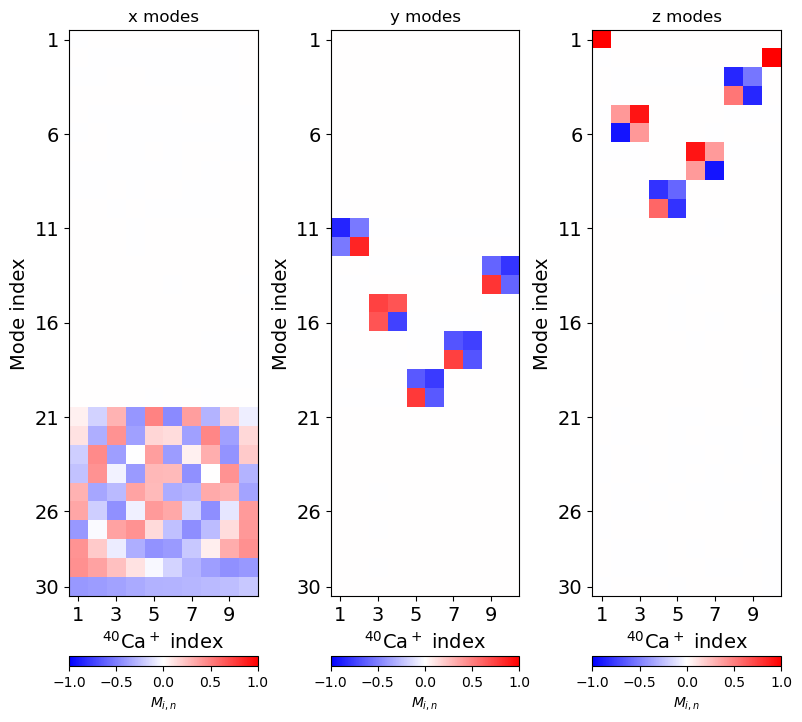

In [25]:
freqs, modes = sn.normal_modes(equilibrium_positions, omegas, ion_masses)
for i, mode in enumerate(modes):
    print(f'Mode index: {i+1}, Frequency: {int(np.round(freqs[i], 0))} Hz')
    print(f'Vector: {list(np.round(mode, 5))}')

fig, ax = plt.subplots(1, 3, figsize = [8, 8])
ax[0].set_title('x modes')
ax[1].set_title('y modes')
ax[2].set_title('z modes')
for i in range(3):
    im = ax[i].imshow(modes[::-1,i*ion_number:(i+1)*ion_number] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
    ax[i].set_xlabel('$^{40}$Ca$^+$ index', fontsize = 14)
    ax[i].set_ylabel('Mode index', fontsize = 14)
    ax[i].set_xticks([0, 2, 4, 6, 8],[1, 3, 5, 7, 9],fontsize = 14)
    ax[i].set_yticks([0, 5, 10, 15, 20, 25, 29],[1, 6, 11, 16, 21, 26, 30], fontsize = 14)
    cb = fig.colorbar(im, ax=ax[i], orientation='horizontal', shrink = 1, pad = 0.08)
    cb.set_label('$M_{i,n}$')
    
plt.tight_layout()
plt.savefig('ind_wells_norm_modes.eps')
plt.show()

# Mode rotation optimization

## Trap definition

In this block we define the five-wire trap, which will be used for both mode and positions optimization. The trap consists of 15 DC electrodes on each site, producing 5 potential wells in axial direction. The trap is symmetric in a sense, that rf electrodes have the same width. This means, that the highest trap depth will be achieved in configuration with mode axes $x$ and $y$ are parallel to the surface. Often optical adressing system is parallel to the surface, which means that in such configuration the $z$ mode will not be adressed. This leads to decreased efficiency of laser cooling, which is undesirable. So it may be convenient to rotate radial modes in $y$-$z$ plane. *Sion* performs voltage optimization to rotate radial modes by the specified angle, minimizing the micromotion.

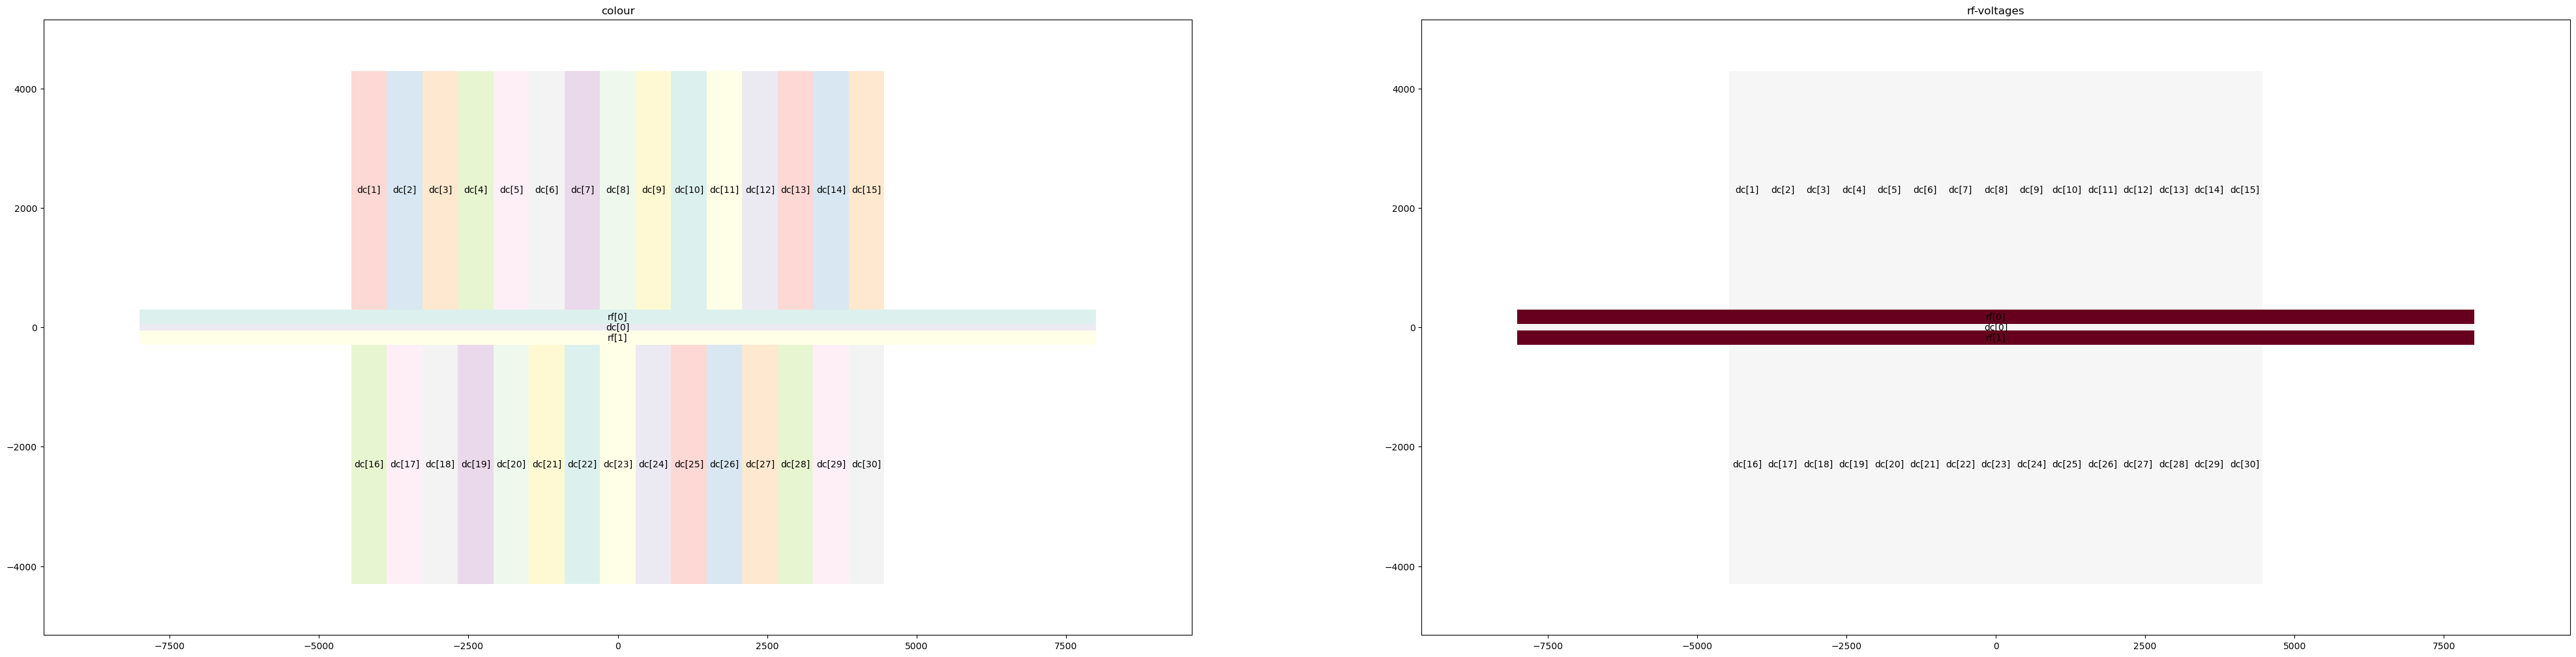

In [2]:
# Global definition of trap parameters.
L = 1e-6 # length scale
Vrf = 200 # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
top_dc =[[595, 4000]]*15
bottom_dc = top_dc  # Array of lengths and widths of Bottom electrodes
central_dc = [16000, 90]
gap = 20  # width of gaps between electrodes
rftop = [16000, 220]  # width of top rf electrode
rfbottom = rftop  # width of bottom rf electrode
s, RF_electrodes, DC_electrodes = sn.five_wire_trap_design(Urf, top_dc ,bottom_dc, rftop, rfbottom, central_dc, gap=gap,
                                                            need_coordinates = True, need_plot = True, figsize=(50,40))

RF minimum: (0, 3.87e-16, 127) um
Potential minimum: (-1.02e-16, -1.12e-16, 127) um
Distance from RF minimum: [-0.   -0.    0.02] um
Secular frequencies: (0.8317, 5.516, 5.713) MHz
In directions 
 [[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.16573418e-15]
 [ 0.00000000e+00 -1.22124533e-15  1.00000000e+00]]
Angle of secular modes rotation alpha: 0.0
Anisotropy parameter: 0.0201


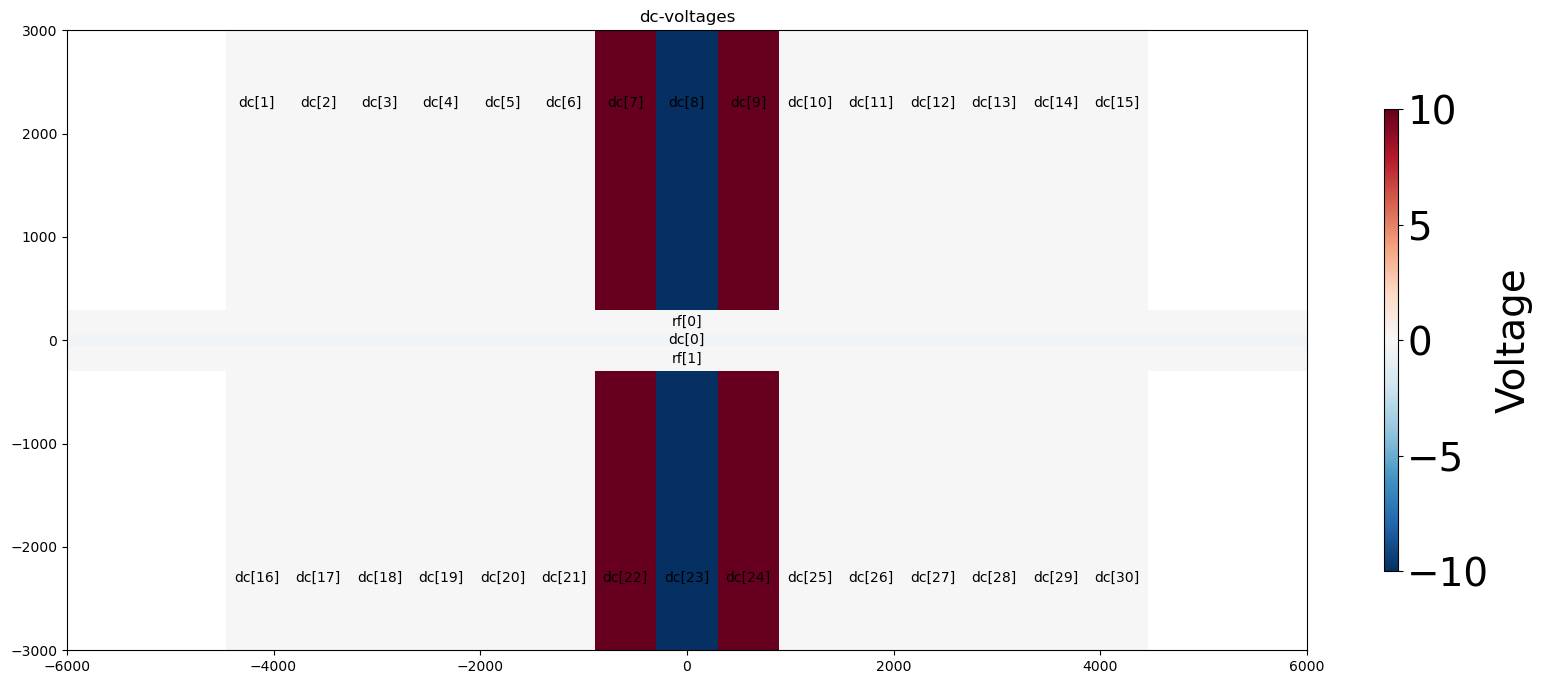

In [38]:
xn = np.array(s.minimum((0., 0, 1), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter':10000}))
print('RF minimum: (%.3g, %.3g, %.3g) um' % (xn[0], xn[1], xn[2]))

dc_set = [-0.36] + [0]*6 + [10,-10,10] + [0]*6 +[0]*6 + [10,-10,10]+[0]*6
dc_set = np.array(dc_set)

rf_set = [Vrf, Vrf]
u_set = np.zeros(len(rf_set))
u_set = np.concatenate([u_set, dc_set])

# routine to find secular frequencies in minimum point
with s.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x0 = s.minimum((xn*1.001), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter':10000})
    print('Potential minimum: (%.3g, %.3g, %.3g) um' % (x0[0], x0[1], x0[2]))
    print('Distance from RF minimum:', np.round((x0-xn), 3), 'um')
    # Get trap frequencies
    try:
        curv_z, mod_dir = s.modes(x0, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        omega_sec, modes = sn.single_ion_modes(s, x0, mass, L=L, charge=1, 
                                                    mathieu=True, r=2, Omega=Omega)
        print("In directions \n", mod_dir)
        e1 = np.array([0,0,1])
        alp = np.arccos(np.inner(mod_dir[2],e1))
        print('Angle of secular modes rotation alpha:', alp)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6

with s.with_voltages(dcs = u_set):    
    
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    s.plot_voltages(ax, u=s.dcs)
    #u = s.dcs sets the voltage-type for the voltage plot to DC-voltages (RF are not shown)
    xmax = 6000
    ymaxn = 3000
    ymaxp = 3000
    ax.set_title("dc-voltages")
    ax.set_aspect('equal')
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymaxn, ymaxp)
    #Add colorbar
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(u_set), vmax=np.max(u_set))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink = 0.6, aspect = 35)
    
    """cb = plt.colorbar(ax=ax[2], shrink=0.9)"""
    cb.ax.tick_params(labelsize=28)
    cb.set_label('Voltage', fontsize = 28)


## Optimization routine

Mode rotation angle is optimized via *sion.mode_optimization()* function. This particular function is very dependent on the initial guess. In general it is good to displace initial potential minimum from the RF potential minimum as an initial guess. It works only for the single potential well, although it can be easily scaled to optimize an arbitrary mode configuration from the source.

In [35]:
alpha = 0.3

numbers = np.array([0, 7, 8, 9, 22, 23, 24])
dc_set[[numbers]] = np.array([-0.36, 9,-9, 9, 10,-10, 10])

optimized_dc_set = sn.mode_optimization(s, alpha=alpha, potential_minimum=x0, start_dcset=dc_set, numbers=numbers, eps=1e-9, tol=1e-26,
                                        callback_num=1000, micro=1, voltage_bounds=(-10,10))

Initial loss = 0.1400633635473388


Optimizing voltages: 119it [00:04, 24.35it/s]

Final loss = 3.0224609633990484e-13
Final uset = [-1.1608673331351482, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.140375579424683, -9.999999821453969, 6.538267840505809, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.212573204648618, -9.490820186765387, 7.814682254944771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Results

Here we demonstrate the resulting voltages and mode angle in radial plane.

Potential minimum: (-1.17e-07, 1.03e-05, 127) um
Distance from RF minimum: [-0.    0.    0.02] um
Secular frequencies: (0.771, 5.617, 5.622) MHz
In directions 
 [[ 9.99997503e-01 -2.13448903e-03 -6.61657178e-04]
 [ 2.23468843e-03  9.55010538e-01  2.96563449e-01]
 [-1.12185030e-06 -2.96564187e-01  9.55012923e-01]]
Angle of secular modes rotation alpha: 0.3010929732005956
Anisotropy parameter: 0.0188


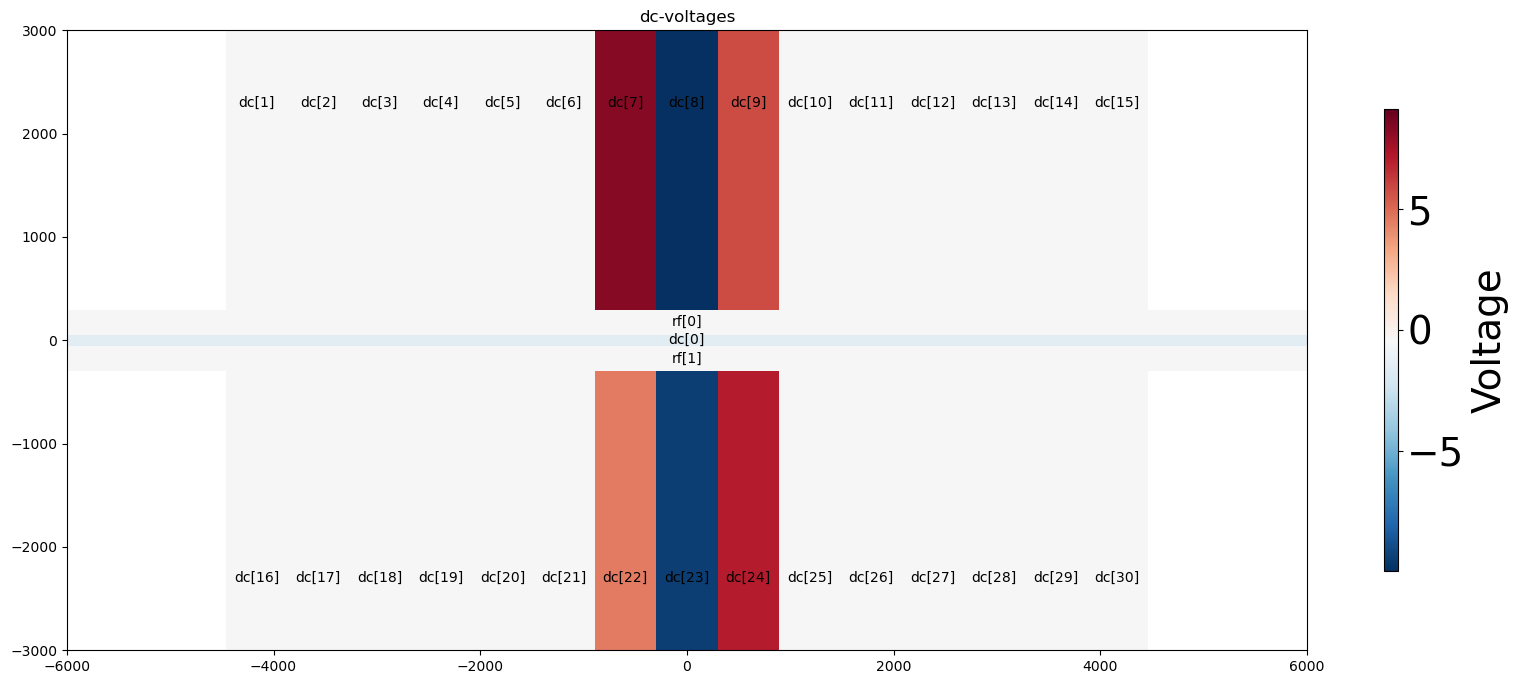

In [36]:
u_set = np.concatenate([np.zeros(len(rf_set)), optimized_dc_set])

# routine to find secular frequencies in minimum point
with s.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x0 = s.minimum((xn*1.001), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter':10000})
    print('Potential minimum: (%.3g, %.3g, %.3g) um' % (x0[0], x0[1], x0[2]))
    print('Distance from RF minimum:', np.round((x0-xn), 3), 'um')
    # Get trap frequencies
    try:
        curv_z, mod_dir = s.modes(x0, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        print("In directions \n", mod_dir)
        e1 = np.array([0,0,1])
        alp = np.arccos(np.inner(mod_dir[2],e1))
        print('Angle of secular modes rotation alpha:', alp)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6

with s.with_voltages(dcs = u_set):    
    
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    s.plot_voltages(ax, u=s.dcs)
    #u = s.dcs sets the voltage-type for the voltage plot to DC-voltages (RF are not shown)
    xmax = 6000
    ymaxn = 3000
    ymaxp = 3000
    ax.set_title("dc-voltages")
    ax.set_aspect('equal')
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymaxn, ymaxp)
    #Add colorbar
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(u_set), vmax=np.max(u_set))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink = 0.6, aspect = 35)
    
    """cb = plt.colorbar(ax=ax[2], shrink=0.9)"""
    cb.ax.tick_params(labelsize=28)
    cb.set_label('Voltage', fontsize = 28)
    plt.show()

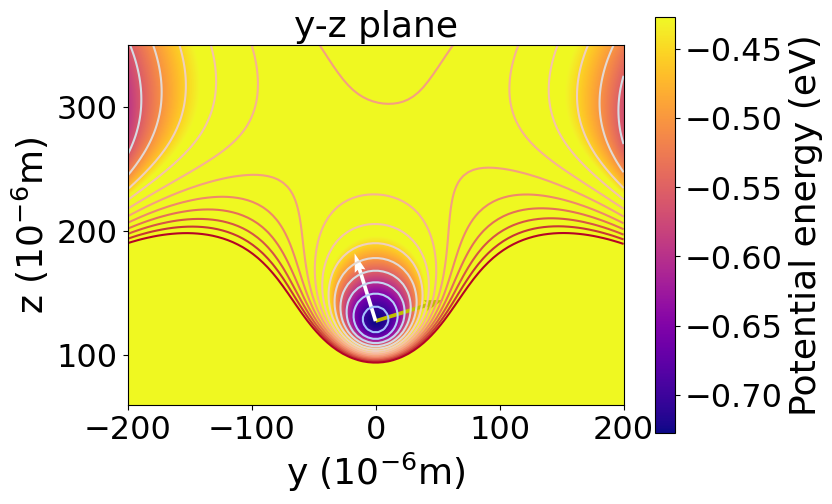

In [37]:
 # #Plot the pseudopotential
with s.with_voltages(dcs = u_set, rfs = None):
    # 2D plot settings
    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -500, 500 #set the plot ranges
    ymin, ymax = -200, 200
    zmin, zmax = 60, 350
    x_cut, y_cut, z_cut = 0, 0, x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(-1, 0, 0.05) # set the range for contour lines (range in eV)
    v_min, v_max = s.potential(x0)[0], s.potential(x0)[0] + 0.3 # set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    # y-z cross section
    fig, ax3 = plt.subplots(1,1, figsize=(8, 6))
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
    ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 
    
    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.9)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)
    
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

# Positions optimization

## Initial dc_set

Optimization of potential minimum positions does not perform with maximize trap depth. Because of this, it is beneficial to provide initial voltages, which create potential minimums at approximately required positions. In this block we make initial set of DC voltages for 5 potential wells.

RF minimum: (0, 3.87e-16, 127) um
Potential minimum: (-7.48e-17, -3.36e-15, 124) um
Distance from RF minimum: [-0.    -0.    -3.021] um
Secular frequencies: (0.8513, 5.731, 6.325) MHz
In directions 
 [[ 1.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  8.8817842e-16]
 [ 0.0000000e+00 -8.8817842e-16  1.0000000e+00]]
Angle of secular modes rotation alpha: 0.0
Anisotropy parameter: 0.0176


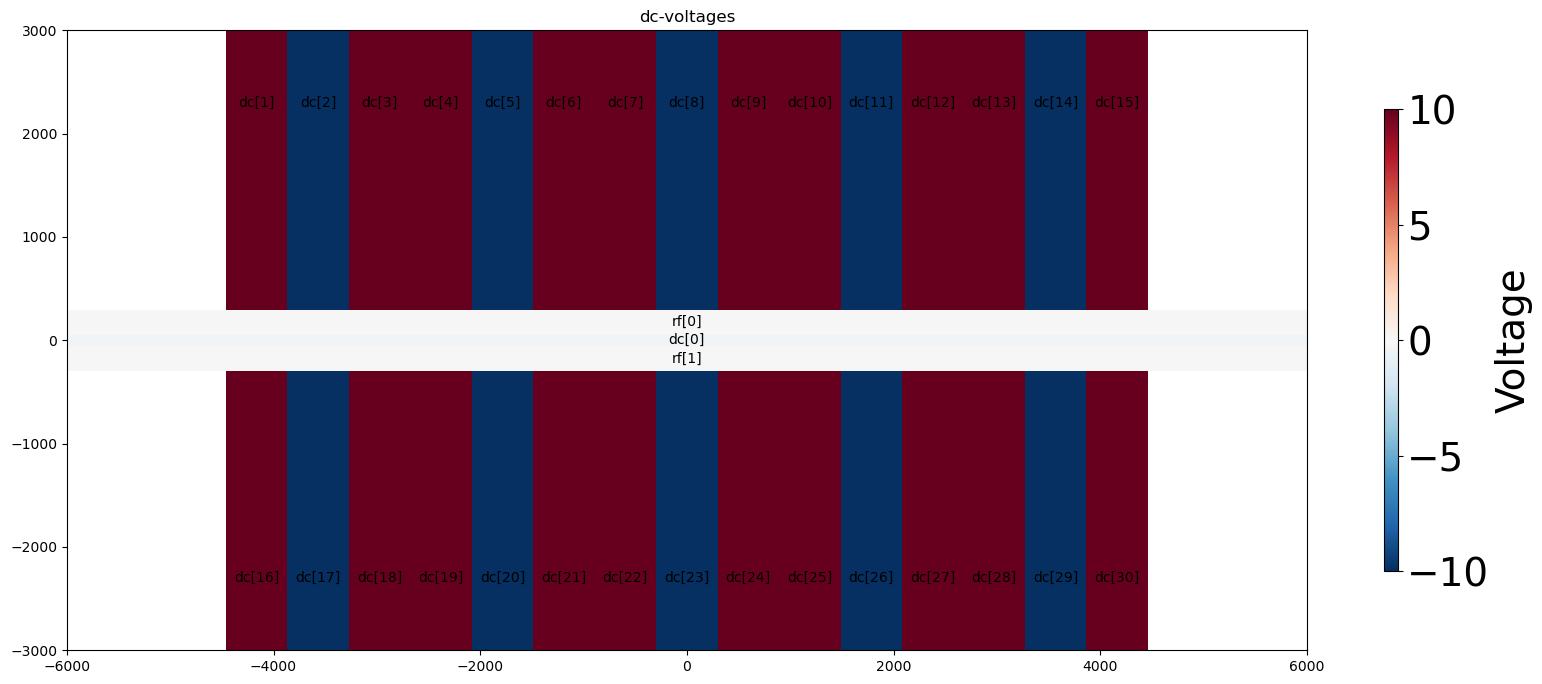

In [3]:
xn = np.array(s.minimum((0., 0, 1), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter':10000}))
print('RF minimum: (%.3g, %.3g, %.3g) um' % (xn[0], xn[1], xn[2]))

dc_set = [-0.36] + [10,-10,10]*10
dc_set = np.array(dc_set)

rf_set = [Vrf, Vrf]
u_set = np.zeros(len(rf_set))
u_set = np.concatenate([u_set, dc_set])

# routine to find secular frequencies in minimum point
with s.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x0 = s.minimum((xn*1.001), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter':10000})
    print('Potential minimum: (%.3g, %.3g, %.3g) um' % (x0[0], x0[1], x0[2]))
    print('Distance from RF minimum:', np.round((x0-xn), 3), 'um')
    # Get trap frequencies
    try:
        curv_z, mod_dir = s.modes(x0, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        omega_sec, modes = sn.single_ion_modes(s, x0, mass, L=L, charge=1, 
                                                    mathieu=True, r=2, Omega=Omega)
        print("In directions \n", mod_dir)
        e1 = np.array([0,0,1])
        alp = np.arccos(np.inner(mod_dir[2],e1))
        print('Angle of secular modes rotation alpha:', alp)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6

with s.with_voltages(dcs = u_set):    
    
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    s.plot_voltages(ax, u=s.dcs)
    #u = s.dcs sets the voltage-type for the voltage plot to DC-voltages (RF are not shown)
    xmax = 6000
    ymaxn = 3000
    ymaxp = 3000
    ax.set_title("dc-voltages")
    ax.set_aspect('equal')
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymaxn, ymaxp)
    #Add colorbar
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(u_set), vmax=np.max(u_set))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink = 0.6, aspect = 35)
    
    """cb = plt.colorbar(ax=ax[2], shrink=0.9)"""
    cb.ax.tick_params(labelsize=28)
    cb.set_label('Voltage', fontsize = 28)

## Optimization routine

We use *sion.position_optimization* to find voltage set, leading to the desired potential well positions. 

In [5]:
positions = [(-3600, 0, 127), (-1800, 0, 127), (-0, 0, 127), (1800, 0, 127), (3600, 0, 127)]

optimized_dc_set = sn.position_optimization(s, positions, dc_set, callback_num=100, voltage_bounds=(-10,10))

Initial loss = 854.5424357245214


Optimizing voltages: 100it [00:48,  2.66it/s]

Current loss = 1.720875581589573e-11
Current uset = [0.25887309979498896, 8.196851271823498, -8.30664816293089, 9.963356213992553, 8.063161674643421, -9.638895994225665, 9.98871237212703, 9.247350908606082, -9.997122657015185, 9.250411903194326, 9.987771316965038, -9.637226015884044, 8.05822743087616, 9.972525654846171, -8.303515101747095, 8.181424027400265, 8.169317565246455, -8.301378691337238, 9.970703736509805, 8.045825011914497, -9.635909850016644, 9.990569792545188, 9.251486359176491, -9.99766386498264, 9.249046945802181, 9.988420821974383, -9.635037511752474, 8.049192435149116, 9.956621513817531, -8.3005810159635, 8.181120502040946]


Optimizing voltages: 137it [01:50,  1.24it/s]

Final loss = 9.336719503909003e-14
Final uset = [0.25887248162713794, 8.196850250968444, -8.306650124199816, 9.963355428611024, 8.063162412719011, -9.63889860679435, 9.988711674612741, 9.247359520324585, -9.997125897847745, 9.250404452585377, 9.987771293039106, -9.63722656320717, 8.058226049918536, 9.97252582529249, -8.303514533016521, 8.181423767940235, 8.169316572175704, -8.301380775648425, 9.97070299287306, 8.045825770596917, -9.63591250369099, 9.990569188635288, 9.251495986565443, -9.99766706418411, 9.249040524493301, 9.98842096700225, -9.635037888482112, 8.049191103882915, 9.956621660432766, -8.300580569539799, 8.181120240084892]


In [6]:
u_set = [0,0]
#dc_set = [0.25887309979498896, 8.196851271823498, -8.30664816293089, 9.963356213992553, 8.063161674643421, -9.638895994225665, 9.98871237212703, 9.247350908606082, -9.997122657015185, 9.250411903194326, 9.987771316965038, -9.637226015884044, 8.05822743087616, 9.972525654846171, -8.303515101747095, 8.181424027400265, 8.169317565246455, -8.301378691337238, 9.970703736509805, 8.045825011914497, -9.635909850016644, 9.990569792545188, 9.251486359176491, -9.99766386498264, 9.249046945802181, 9.988420821974383, -9.635037511752474, 8.049192435149116, 9.956621513817531, -8.3005810159635, 8.181120502040946]
u_set = np.concatenate([u_set, optimized_dc_set])

with s.with_voltages(dcs=u_set, rfs=None):
    for j, xx in enumerate(positions):
        x0 = s.minimum((np.array(xx)*1.001), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter':10000})
        print(f'Potential minimum [{j}]: {np.round(x0)} um')

Potential minimum [0]: [-3600.     0.   127.] um
Potential minimum [1]: [-1800.    -0.   127.] um
Potential minimum [2]: [  0.  -0. 127.] um
Potential minimum [3]: [1800.   -0.  127.] um
Potential minimum [4]: [3600.    0.  127.] um


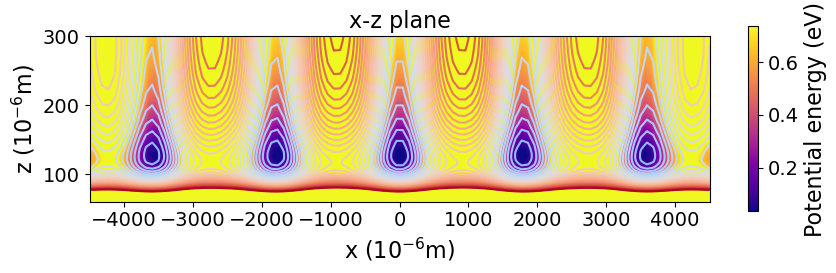

In [28]:
 # #Plot the pseudopotential
with s.with_voltages(dcs = u_set, rfs = None):
    # 2D plot settings
    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -4500, 4500 #set the plot ranges
    ymin, ymax = -200, 200
    zmin, zmax = 60, 300
    x_cut, y_cut, z_cut = 0, 0, x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(-1, 3, 0.1) # set the range for contour lines (range in eV)
    v_min, v_max = s.potential(x0)[0], s.potential(x0)[0]+0.7 # set the range for colour map (range in eV)
    fs = 16 #set the fontsize
    ls = 14 #set the labelsize

    # x-z cross section
    fig,ax2 = plt.subplots(1,1, figsize=(10,4))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (b.reshape(n, n) for b in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')
    ax2.set_aspect(10)
    # add colorbar
    cb = fig.colorbar(im, ax=ax2, shrink=0.6)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)
    